<h2 style="text-align: center;"><b>Распознавание рукописных символов: MNIST</b></h2>

В этом ноутбке мы напишем сверточную нейронную сеть на фреймворке PyTorch, и протестируем ее работу на датасете MNIST.

Рассмотрим ***задачу классификации изображений***.

***Сверточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоев* (а иногда их может и не быть) еще и **сверточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свертки**.

Сразу же стоит сказать, что сверточные нейросети **были придуманы прежде всего для задач, связанных с изображениями**, следовательно, на вход они тоже "ожидают" изображение.

* Например, вот так выглядит неглубокая сверточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`


Сверточные нейросети (простые, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*L -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок -- тензор размера `(batch_size, H, W, C)`)  

2). $M$ блоков (M $\ge$ 0) из сверток и pooling-ов, причем именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** сверточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $L$ штук FullyConnected-слоев (с активациями). Эту часть из $L$ FC-слоев называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Сверточная нейросеть на PyTorch</b></h3>

Еше раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можно начинать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на датасете MNIST.

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [2]:
#!pip install torch torchvision  #Если до этого момента вы не устанавливали PyTorch, то это можно сделать при помощи
                                 #указанной команды

In [1]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Скачаем и загрузим данные в `DataLoader`'ы: Понадобится подключение к сети Интернет.

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [32]:
trainloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

In [33]:
testloader.dataset.test_data.shape

torch.Size([10000, 28, 28])

Выведем первую картинку:

In [34]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [6]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

In [7]:
numpy_img.shape

(28, 28)

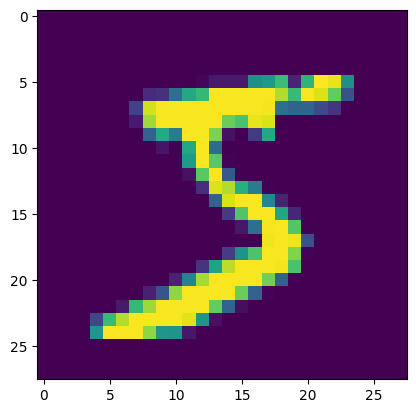

In [8]:
plt.imshow(numpy_img);

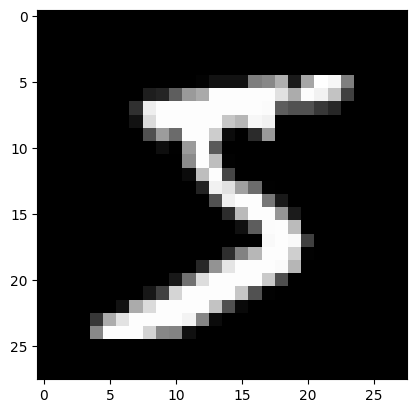

In [9]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

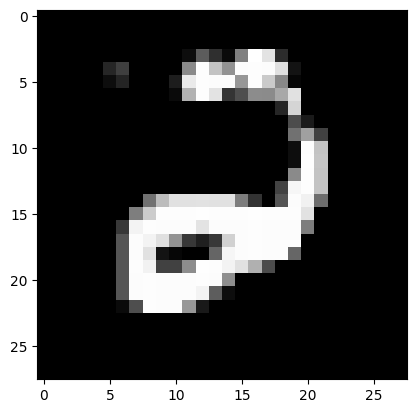

In [10]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

In [17]:
trainloader.dataset.targets[i]


tensor(2)

Как итерироваться по данным с помощью `loader'`а? Очень просто, при помощи цикла:

In [19]:
for data in trainloader:
    print(len(data))
    print('Images:',data[0].shape)
    print('Labels:', data[1].shape)
    break

2
Images: torch.Size([4, 1, 28, 28])
Labels: torch.Size([4])
tensor([5, 8, 1, 5])


То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причем в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернемся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Sequential`. Со второй мы уже встречались в предыдущих ноутбуках по нейросетям, теперь мы используем именно `Functional` парадигму, потому что при построении сверточных сетей это намного удобнее:

In [20]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [27]:
# Заметьте: класс наследуется от nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        # один канал означает, что изображение черно-белое, три - цветное
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятное число `4 * 4 * 16`. Это -- размерность тензора перед FC-слоями (H x W x C), ее приходиться высчитывать вручную (в Keras, например, `.Flatten()` все сделает за вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в `C * H * W` нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [ ]:
from tqdm import tqdm_notebook

In [35]:
# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(1)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 50 батчей
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Обучение закончено')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Обучение закончено


Протестируем на всем тестовом датасете, используя метрику accuracy_score:

In [36]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 95 %
Accuracy of     2 : 82 %
Accuracy of     3 : 87 %
Accuracy of     4 : 91 %
Accuracy of     5 : 85 %
Accuracy of     6 : 85 %
Accuracy of     7 : 89 %
Accuracy of     8 : 93 %
Accuracy of     9 : 88 %


Два сверточных слоя оказались эффективнее многослойной нейронной сети. Это показывает эффективность применения операции свертки при работе с изображениями.

Протестируем эту нейросеть на отдельных картинках из тестового датасета: напишием функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает ее, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

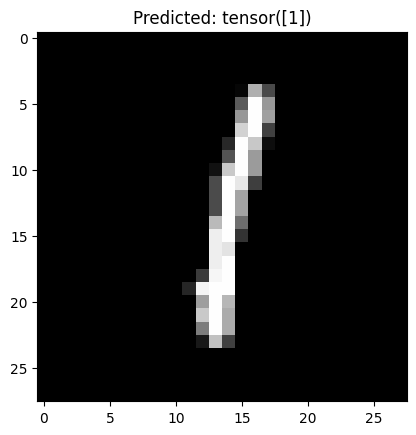

In [62]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.test_data[index].numpy()
    plt.imshow(image, cmap='gray')
    
    y_pred = net(torch.Tensor(image).view(1, 1, 28, 28))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {predicted}')

visualize_result(i)

Можете запускать ячейку выше много раз (нажимая Ctrl+Enter) и видеть, что предсказывает нейросеть в зависимости от поданной на вход картинки.